In [ ]:
from google.colab import drive
import pandas as pd
import tensorflow as tf
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
MODEL_PATH = '/content/drive/MyDrive/FakeNewsModel 1.1'
NEW_DATA_PATH = '/content/drive/MyDrive/Datasets/news_dataset.csv'  
SAVE_PATH = '/content/drive/MyDrive/FakeNewsModel 1.2'  


In [ ]:
try:
    data = pd.read_csv(NEW_DATA_PATH)
    data['text'] = data['text'].astype(str)  

    data['label'] = data['label'].apply(
        lambda x: 0 if str(x).lower().strip() in ['real', 'true'] else 1
    )

    print(f"\nTotal samples: {len(data)}")
    print("Class distribution:")
    print(data['label'].value_counts())

except Exception as e:
    print(f"\nError loading data: {e}")
    raise



Total samples: 3729
Class distribution:
label
1    1877
0    1852
Name: count, dtype: int64


In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['text'].values,
    data['label'].values,
    test_size=0.2,
    random_state=42
)

In [ ]:
try:
    print("\nLoading existing model...")
    tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_PATH)
    model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_PATH)
    print("Successfully loaded existing model!")
except Exception as e:
    print(f"\nFailed to load model: {e}")
    print("Initializing new model instead...")
    tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
    model = TFDistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=2
    )


Loading existing model...


All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/FakeNewsModel 1.1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Successfully loaded existing model!


In [ ]:
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)

In [ ]:
def create_tf_dataset(encodings, labels):
    return tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask']
        },
        labels
    )).batch(16)

train_dataset = create_tf_dataset(train_encodings, train_labels)
test_dataset = create_tf_dataset(test_encodings, test_labels)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [ ]:
print("\nStarting retraining...")
history = model.fit(
    train_dataset,
    epochs=3,
    validation_data=test_dataset
)



Starting retraining...
Epoch 1/3
187/187 [==============================] - 69s 239ms/step - loss: 0.0587 - accuracy: 0.9799 - val_loss: 0.0178 - val_accuracy: 0.9946
Epoch 2/3
187/187 [==============================] - 41s 218ms/step - loss: 0.0132 - accuracy: 0.9960 - val_loss: 0.0141 - val_accuracy: 0.9933
Epoch 3/3
187/187 [==============================] - 43s 233ms/step - loss: 0.0027 - accuracy: 0.9990 - val_loss: 0.0120 - val_accuracy: 0.9987


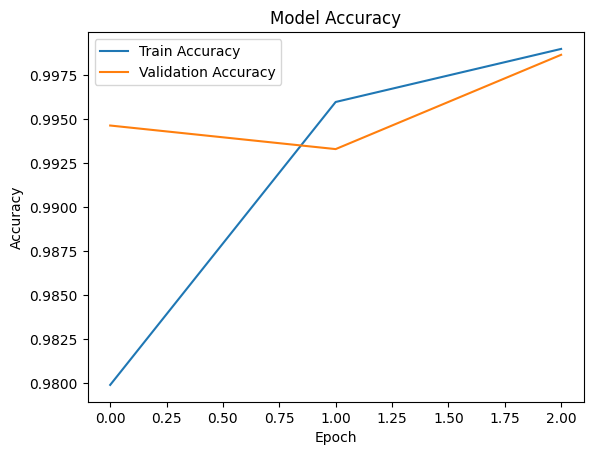

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('/content/drive/MyDrive/train1.2.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
model.save_pretrained(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)
print(f"\nRetrained model saved to {SAVE_PATH}")


Retrained model saved to /content/drive/MyDrive/FakeNewsModel 1.2


In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print(f"\nFinal Test Accuracy: {accuracy:.2%}")
print(f"Test Loss: {loss:.4f}")

47/47 [==============================] - 3s 71ms/step - loss: 0.0120 - accuracy: 0.9987

Final Test Accuracy: 99.87%
Test Loss: 0.0120
